#  Setting the environment: full power.
_Or: making gym environment happy  with your very own backtrader engine._
****

> **This example assumes close familarity with  Backtrader conceptions and operation worflow.**
> 
> **One should at least run through Quickstart tutorial:  https://www.backtrader.com/docu/quickstart/quickstart.html**

### Typical workfolw for traditional Backtrader backtesting procedure (recap):
- Define backtrader core engine:
  
``` python
    import backtrader as bt
    import backtrader.feeds as btfeeds
    engine = bt.Cerebro()
```

- Add some starategy class, wich has been prepared in advance as backtrader base Strategy() subclass and should define  decision-making logic:
 
``` python
    engine.addstrategy(MyStrategy)
```
     
- Set broker options, such as: cash, commission, slippage, etc.:
 
``` python
    engine.setcash(100000)
    engine.setcommission(0.001)
```
    
- Add analyzers, observers, sizers, writers to own needs:
 
``` python
    engine.addobserver(bt.observers.Trades)
    engine.addobserver(bt.observers.BuySell)
    engine.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    engine.addsizer(bt.sizers.SizerFix, stake=1000)
```
     
- Define and add data feed from one or another source (live feed is possible):
 
``` python
    MyData = btfeeds.GenericCSVData(dataname=CSVfilename.csv)
    engine.addata(MyData)
```
     
- Now backtrader enigine is ready to run backtesting:
 
``` python
   results = engine.run()
```
 
- After that you can print, analyze and think on results:
 
``` python
    engine.plot()
    my_disaster_drowdown = results[0].analyzers.drawdown.get_analysis()
```

***
### For BTgym,  same principles apply with several differences:

 - strategy you prepare will be subclass of base BTgymStrategy,
   wich contains specific to RL setup methods and parameters;
   
    
 - this startegy will not contain buy/sell decision-making logic - this part will go to RL agent;
   
 
 - you define you dataset by creating BTgymDataset class instance;
   
 
 - you don't add data to your bt.cerebro(). Just pass dataset to environment, BTgym server will do the rest.
   
 
 - you dont run backtrader engine manually via run() method, server will do.
 

****
### There are three levels to  BTgym configuration:
#### [Light:](https://github.com/Kismuz/btgym/blob/master/examples/setting_up_environment_basic.ipynb) 
 - use kwargs when making envronment. See 'basic' example for details;
  
   
#### [3/4:](#3/4) 
- subclass BTgymStrategy: override **`get_state(), get_done(), get_reward(), get_info()`**
  and [maybe] **`next()`** methods to get own state, reward definition, order execution logic, actions etc;
- pass this strategy to environment via **`strategy`** kwarg along with other parameters;
- [optionally] make instance of **`BTgymDataset`** class as your custom dataset an pass it via **`dataset`** kwarg.
 
  
#### [Full throttle:](#full)
 - subclass strategy as in '3/4';
 - define bt.Cerebro(): set broker parameters, add all required observers,
   analysers, stakes and other bells and whistles;
 - attach your '3/4'-strategy;
 - pass that snowball to environment via **`engine`** kwarg;
 - [opt.] make and pass dataset as in '3/4'.


***
### Environment kwargs reference:
**as for v0.0.4**
```python

# Dataset parameters:
filename=None,  # Source CSV data file;
    # Episode data params:
start_weekdays=[0, 1, 2, ],  # Only weekdays from the list will be used for episode start.
start_00=True,  # Episode start time will be set to first record of the day (usually 00:00).
episode_len_days=1,  # Maximum episode time duration in d:h:m:
episode_len_hours=23,
episode_len_minutes=55,
time_gap_days=0,  # Maximum data time gap allowed within sample in d:h.
time_gap_hours=5,  # If set < 1 day, samples containing weekends and holidays gaps will be rejected.


# Backtrader engine parameters:
start_cash=10.0,  # initial trading capital.
broker_commission=0.001,  # trade execution commission, default is 0.1% of operation value.
fixed_stake=10,  # single trade stake is fixed type by def.


# Strategy related parameters:
state_shape=(4, 10),
    # observation state shape, by convention last dimension is time embedding;
    # one can define any shape; match env.observation_space.shape.
state_low=None,  # observation space state min/max values,
state_high=None,  # if set to None - absolute min/max values from BTgymDataset will be used.
drawdown_call=90,  # episode maximum drawdown threshold, default is 90% of initial value.
portfolio_actions=('hold', 'buy', 'sell', 'close'),
    # agent actions,
    # should consist with BTgymStrategy order execution logic;
    # defaults are (env.side): 0 - 'do nothing', 1 - 'buy', 2 - 'sell', 3 - 'close position'.
skip_frame=1,
    # Number of environment steps to skip before returning next response,
    # e.g. if set to 10 -- agent will interact with environment every 10th episode step;
    # Every other step agent's action is assumed to be 'hold'.
    # Note: INFO part of environment response is a list of all skipped frame's info's,
    #       i.e. [info[-9], info[-8], ..., info[0].


# Other:
port=5500,  # network port to use.
network_address='tcp://127.0.0.1:',  # using localhost.
verbose=0,  # verbosity mode: 0 - silent, 1 - info level, 2 - debugging level (lot of traffic!).

```

***
### Kwargs applying logic:
    
        if <engine> kwarg is given:
            do not use default engine and strategy parameters;
            ignore <startegy> kwarg and all startegy and engine-related kwargs;
        
        else (no <engine>):
            use default engine parameters;
            if any engine-related kwarg is given:
                override corresponding default parameter;
            
            if <strategy> is given:
                do not use default strategy parameters;
                if any strategy related kwarg is given:
                    override corresponding strategy parameter;
                
            else (no <strategy>):
                use default strategy parameters;
                if any strategy related kwarg is given:
                    override corresponding strategy parameter;
        
       if <dataset> kwarg is given:
            do not use default dataset parameters;
            ignore dataset related kwargs;
                    
        else (no <dataset>):
            use default dataset parameters;
                if  any dataset related kwarg is given:
                    override corresponding dataset parameter;
        
        If any <other> kwarg is given:
            override corr. default parameter.

***
### <a name="3/4"></a> 3/4. 'State and Reward' with BTgymStrategy.
- There are parameters BTgymStrategy class holds.
- Point it out: it's strategy parameters, not environment ones (though names are the same as above)!
```python
state_shape=(4, 10),
    # observation state shape, by convention last dimension is time embedding;
    # one can define any shape; match env.observation_space.shape.
state_low=None,  # observation space state min/max values,
state_high=None,  # if set to None - absolute min/max values from BTgymDataset will be used.
drawdown_call=90,  # episode maximum drawdown threshold, default is 90% of initial value.
portfolio_actions=('hold', 'buy', 'sell', 'close'),
    # agent actions,
    # should consist with BTgymStrategy order execution logic;
    # defaults are (env.side): 0 - 'do nothing', 1 - 'buy', 2 - 'sell', 3 - 'close position'.
skip_frame=1,
    # Number of environment steps to skip before returning next response,
    # e.g. if set to 10 -- agent will interact with environment every 10th episode step;
    # Every other step agent's action is assumed to be 'hold'.
    # Note: INFO part of environment response is a list of all skipped frame's info's,
    #       i.e. [info[-9], info[-8], ..., info[0].
```
When maiking own subclass, it's one's responsibility to set those in consistency.
 

In [23]:
import sys
sys.path.insert(0,'..')

import IPython.display as Display
import PIL.Image as Image
import numpy as np
import random

from btgym import BTgymEnv, BTgymStrategy, BTgymDataset

# Handy functions:

def show_rendered_image(rgb_array):
    """
    Convert numpy array to RGB image using PILLOW and
    show it inline using IPykernel.
    """
    Display.display(Image.fromarray(rgb_array))

def render_all_modes(env):
    """
    Retrieve and show environment renderings
    for all supported modes.
    """
    for mode in env.metadata['render.modes']:
        print('[{}] mode:'.format(mode))
        show_rendered_image(env.render(mode))

def take_some_steps(env, some_steps):
    """Just does it. Acting randomly."""
    for step in range(some_steps):
        rnd_action = int((env.action_space.n)*random.random())
        o, r, d, i = env.step(rnd_action)
        if d:
            print('Episode finished,')
            break
    print(step+1, 'steps made.\n')
    
def under_the_hood(env):
    """Shows environment parameters."""
    for params_name, params_dict in env.params.items():
        print('\nParameters [{}]: '.format(params_name))
        for key, value in params_dict.items():
            print('{} : {}'.format(key,value))
    print('\nDataset:', env.dataset)
    print('\nStrategy class:', env.strategy)
    print('\nEngine:', env.engine)

### Define simple custom strategy:
Note using of inner startegy variable **`raw_state`**.

In [34]:
class MyStrategy(BTgymStrategy):
    """
    Example subclass of BTgym inner computation startegy,
    overrides default get_state() and get_reward() methods.
    """
    
    def get_state(self):
        """
        Returns normalized environment observation state
        by computing time-embedded vector
        of price gradients.
        """
        # Prepare:
        sigmoid = lambda x: 1/(1 + np.exp(x))
        
        # T is 'gamma-like' signal hyperparameter
        # for our signal to be in about [-5,+5] range before passing it to sigmoid;
        # tweak it by hand to add/remove "peaks supressing":
        T = 1.2e+4
        
        # Use default strategy observation variable to get
        # time-embedded state observation as [4,m] numpy matrix, where
        # 4 - number of signal features  == state_shape[0],
        # m - time-embedding length  == state_shape[-1] == <set by user>.
        X = self.raw_state
        
        # ...while iterating, inner _get_raw_state() method is called just before this one,
        # so variable `self.raw_state` is fresh and ready to use.

        # Compute gradients with respect to time-embedding (last) dimension:
        dX = np.gradient(X)[-1]
        
        # Squash values in [0,1]:
        return sigmoid(dX * T)
    
    def get_reward(self):
        """
        Computes reward as log utility of current to initial portfolio value ratio.
        """
        return float(np.log(self.stats.broker.value[0] / self.env.broker.startingcash))
        

### Configure environment:
- All strategy parameters shown above that are not meant to be ledt defaults should be passed to environmnet as kwargs.
- when `verbose=1`, pay attention to log output what classes been used (base or custom).

In [35]:
# Define dataset:
MyDataset = BTgymDataset(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                         start_weekdays=[0, 1,],
                         # leave all other to defaults,
                        ) 

env = BTgymEnv(dataset=MyDataset,
               strategy=MyStrategy,
               state_shape=(4, 50),
               state_low=0,  
               state_high=1, # sigmoid
               drawdown_call=30,
               skip_frame=5,
               # use default agent actions,
               # use default engine,
               start_cash=100.0,
               # use default commission,
               # use default stake,
               # use default network port,
               render_agent_as_image = False,
               render_ylabel = 'Price Gradient',
               # leave other rendering p. to dedaults,
               verbose=1,
              )

[2017-06-30 18:34:06,626] Custom Dataset class used.
[2017-06-30 18:34:06,627] Base Cerebro class used. Custom Strategy class used.
[2017-06-30 18:34:06,642] Environment is ready.
[2017-06-30 18:34:07,756] Server is exiting. Exit code: None


### Take a look...

In [36]:
under_the_hood(env)


Parameters [dataset]: 
info : Custom Dataset class used.

Parameters [engine]: 
start_cash : 100.0
broker_commission : 0.001
fixed_stake : 10

Parameters [strategy]: 
info : Custom Strategy class used.
state_shape : (4, 50)
state_low : 0
state_high : 1
portfolio_actions : ('hold', 'buy', 'sell', 'close')
skip_frame : 5

Parameters [other]: 
port : 5500
network_address : tcp://127.0.0.1:5500
ctrl_actions : ('_done', '_reset', '_stop', '_getstat', '_render')
verbose : 1
render_agent_as_image : False
render_ylabel : Price Gradient

Dataset: <btgym.datafeed.BTgymDataset object at 0x10dce7128>

Strategy class: <class '__main__.MyStrategy'>

Engine: <backtrader.cerebro.Cerebro object at 0x10dcbc7b8>


***
### Time to run:
- Play with number of steps. Comment out **`env.reset()`** not to restart episode every time you run th cell.
- Refer to 'rendering howto' to get sense of how renerings are updated.

100 steps made.

[human] mode:


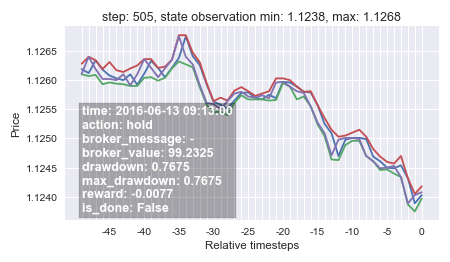

[agent] mode:


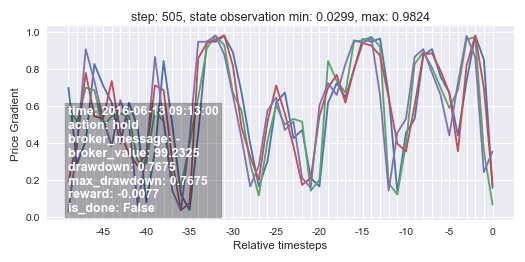

[episode] mode:


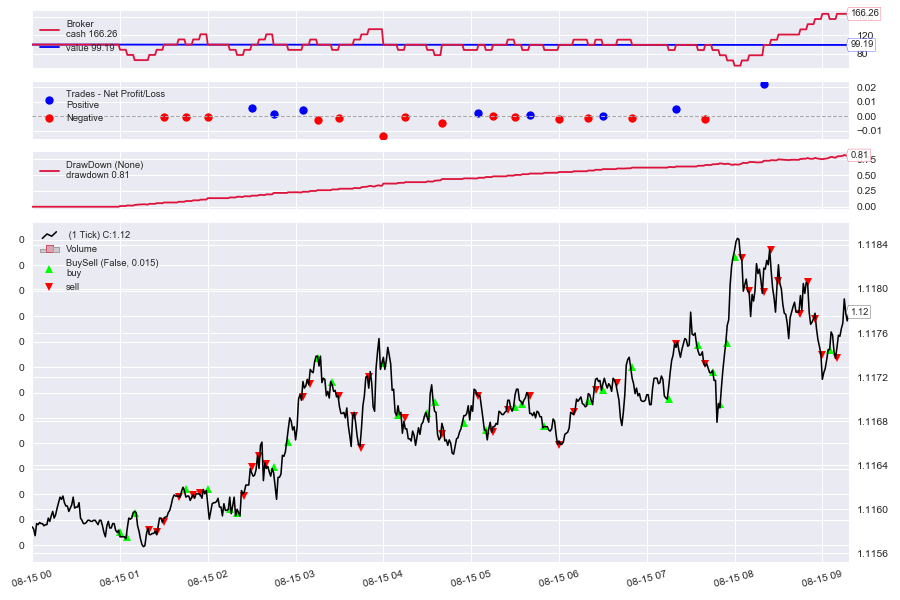

In [40]:
env.reset()
take_some_steps(env, 100)
render_all_modes(env)

****
### <a name="full"></a>Full Throttle setup:
- Summon Backtrader power;
- Wich-is-what: pay attention to arguments being used or ignored.

In [41]:
# Clean up:
env.close()

# Now we need it:
import backtrader as bt

[2017-06-30 18:34:53,915] Server is exiting. Exit code: None


In [54]:
# Define dataset:
MyDataset = BTgymDataset(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                         start_weekdays=[0, 1,],
                         episode_len_days=2,  # episode duration set to about 3 days (2:23:55),
                         episode_len_hours=23,
                         episode_len_minutes=55,
                         # leave all other to defaults,
                        ) 


# Configure backtesting engine:
MyCerebro = bt.Cerebro()

# Note (again): all kwargs here will go stright to strategy parameters dict,
# that is our responsibility to consisit observation shape / bounds with what our get_state() computes.
MyCerebro.addstrategy(MyStrategy,
                      state_shape=(4,50),
                      state_low=0,
                      state_high=1,
                      drawdown_call=99,
                      skip_frame=5,
)

# Than everything is very backtrader'esque:
MyCerebro.broker.setcash(100.0)
MyCerebro.broker.setcommission(commission=0.002)
MyCerebro.addsizer(bt.sizers.SizerFix, stake=20)
MyCerebro.addanalyzer(bt.analyzers.DrawDown)

# Finally:
env = BTgymEnv(dataset=MyDataset,
               episode_len_days=0, # ignored!
               engine=MyCerebro,
               strategy='NotUsed',  # ignored!
               state_shape=(9, 99), # ignored!
               start_cash=1.0,  # ignored!
               render_agent_as_image=False,
               render_ylabel='Price Gradient',   
               render_size_human=(10,4),
               render_size_agent=(10,4),
               render_plotstyle='ggplot',
               verbose=1,
              )

# Look again...
under_the_hood(env)

[2017-06-30 18:53:55,917] No running server found. Hint: forgot to call reset()?
[2017-06-30 18:53:55,918] Server process terminated. Exit code: 1
[2017-06-30 18:53:55,916] Custom Dataset class used.
[2017-06-30 18:53:55,921] Custom Cerebro class used.
[2017-06-30 18:53:55,936] Environment is ready.



Parameters [dataset]: 
info : Custom Dataset class used.

Parameters [engine]: 
info : Custom Cerebro class used.

Parameters [strategy]: 
info : Custom Cerebro class used.
state_shape : (4, 50)
state_low : 0
state_high : 1
portfolio_actions : ('hold', 'buy', 'sell', 'close')
skip_frame : 5

Parameters [other]: 
port : 5500
network_address : tcp://127.0.0.1:5500
ctrl_actions : ('_done', '_reset', '_stop', '_getstat', '_render')
verbose : 1
render_agent_as_image : False
render_ylabel : Price Gradient
render_size_human : (10, 4)
render_size_agent : (10, 4)
render_plotstyle : ggplot

Dataset: <btgym.datafeed.BTgymDataset object at 0x10dd2e080>

Strategy class: NotUsed

Engine: <backtrader.cerebro.Cerebro object at 0x10dd2e128>


100 steps made.

[human] mode:


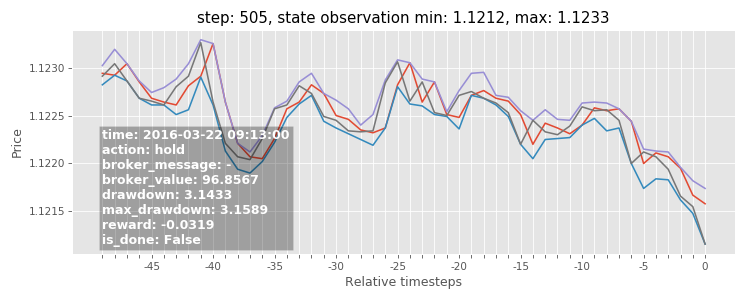

[agent] mode:


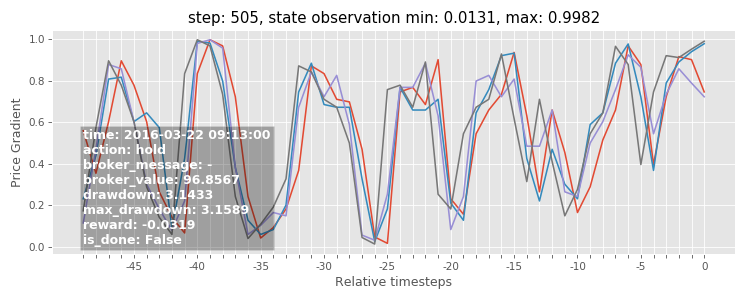

[episode] mode:


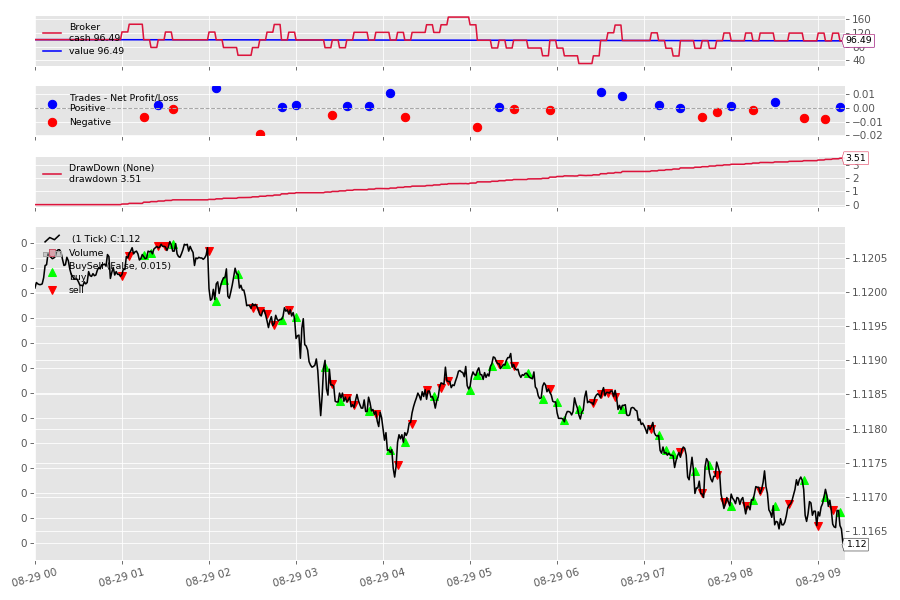

In [57]:
env.reset()
take_some_steps(env, 100)
render_all_modes(env)

In [58]:
# Clean up:
env.close()

[2017-06-30 18:54:47,335] Server is exiting. Exit code: None
